# Quora Similar Question Detection

### Imports

In [81]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import os
from os import path
from wordcloud import WordCloud


## Data

In [3]:
df = pd.read_csv("../../data/train.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
# check what the balance of values are
df['is_duplicate'].value_counts()
# it is about 1.6x which is ok so we can proceed without having to rebalance dataset

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [7]:
# are there null values to clean?
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [13]:
# only a few nulls, lets remove them. 
df = df.loc[~df['question2'].isnull()] 
df = df.loc[~df['question1'].isnull()]
df.shape

(404287, 6)

### Split Data into our Train and Validation Sets
We need to seperate our the validation data so there is no data leak in our training set and we can validate properly

In [34]:
train_size = int(df.shape[0]*.7) #70% for train size
test_size = int(df.shape[0]*.3)       
print("train size:", train_size)
print("test size:", test_size)

df_train = df.sample(n=train_size) 
print("Shape of new dataframe for training:", df_train.shape)

train size: 283000
test size: 121286
Shape of new dataframe for training: (283000, 6)


In [36]:
# now we have a train data set, let make a test datset but ensuring that there are no common questions. 
# this is to ensure the model can be evaluated on net new text based questions 
df_test = df.loc[(~df['id'].isin(df_train['id'])) & (~df['qid1'].isin(df_train['qid1'])) & (~df['qid1'].isin(df_train['qid2'])) & (~df['qid2'].isin(df_train['qid1'])) & (~df['qid2'].isin(df_train['qid2']))] 
print("shape of new test data:", df_test.shape)

# we can see that the test data is smaller than a perfect split of the data as we have removed questions that appear in both questions
# this is because the data is not flat here as each line has 2 questions on it

shape of new test data: (53840, 6)


### EDA 

(283000, 6)


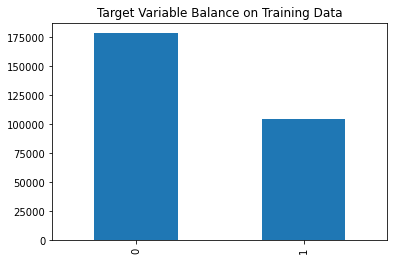

In [58]:
df_train['is_duplicate'].value_counts().plot(kind='bar', title='Target Variable Balance on Training Data')
print(df_train.shape)

(53840, 6)


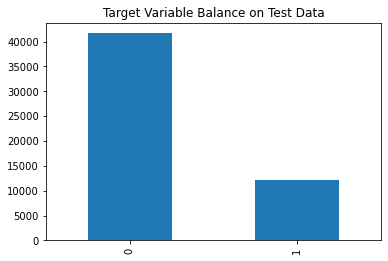

In [47]:
df_test['is_duplicate'].value_counts().plot(kind='bar', title='Target Variable Balance on Test Data')
print(df_test.shape)

In [59]:
# show questions often asked
q1 = df[['qid1', 'is_duplicate']].loc[df['is_duplicate']==1].rename(columns={'qid1':'qs'})
q2 = df[['qid2', 'is_duplicate']].loc[df['is_duplicate']==1].rename(columns={'qid2':'qs'})
qs_popular = pd.concat([q1, q2], axis=0).groupby(by='qs').count().sort_values(by='is_duplicate', ascending=False)
qs_popular.head(10)

,is_duplicate
qs,
28133,56
3595,55
38,54
4951,54
10330,54
13748,54
18296,53
4018,53
20190,52


In [70]:
# show rows from origional data where these top duplicates appear
qs_top = qs_popular.head(10).index
#df.loc[(df['qid1'].isin(qs_top)) | (df['qid2'].isin(qs_top))].drop_duplicates(subset="qid1").drop_duplicates(subset='qid2')

# actually lets make a table with list of unique question IDs and their text 
d1 = df[['qid1', 'question1']].rename(columns={'qid1':'qid', 'question1':'text'})
d2 = df[['qid2', 'question2']].rename(columns={'qid2':'qid', 'question2':'text'})
table_questions = pd.concat([d1,d2], axis=0).drop_duplicates(subset='text')

#filter by top 10 list
qs_top = qs_popular.head(10).index
top_text = table_questions.loc[table_questions['qid'].isin(qs_top)]
top_text = top_text.set_index('qid').loc[qs_top.to_list()]
top_text
# we can see that there aresimilar questions in the top 10 that are not grouped together. 
# messy data, but that is the whole point of this project that we are trying to tackle

,text
qid,
28133,How should I lose weight?
3595,How do i lose weight?
38,Why do people ask Quora questions which can be...
4951,Why do people ask questions on Quora that can ...
10330,How do I lose weight?
13748,How will the scrapping of Rs 500 and Rs 1000 n...
18296,Why do some people on QUORA ask questions that...
4018,How would demonetizing 500 and 1000 rupee note...
20190,What do you think about ban on Rs. 500 and Rs....


#### Wordcloud Fun
Lets make a quick wordcloud of all text

In [80]:
# write all raw question text to csv file..
# we will use this for our wordcloud
df[['question1', 'question2']].to_csv(r'../../data/raw_text.txt', header=None, index=None, sep=' ', mode='a')

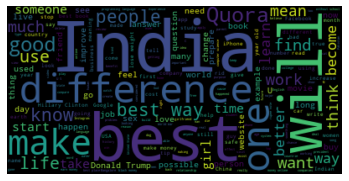

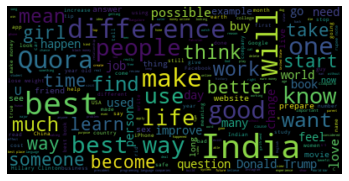

In [86]:
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = open(path.join(d, '../../data/raw_text.txt')).read()

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

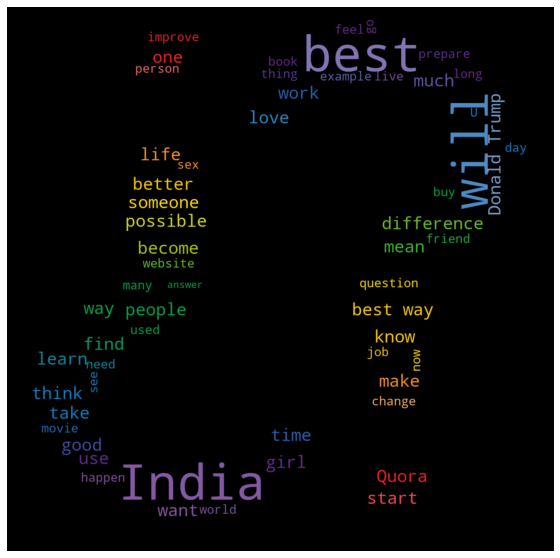

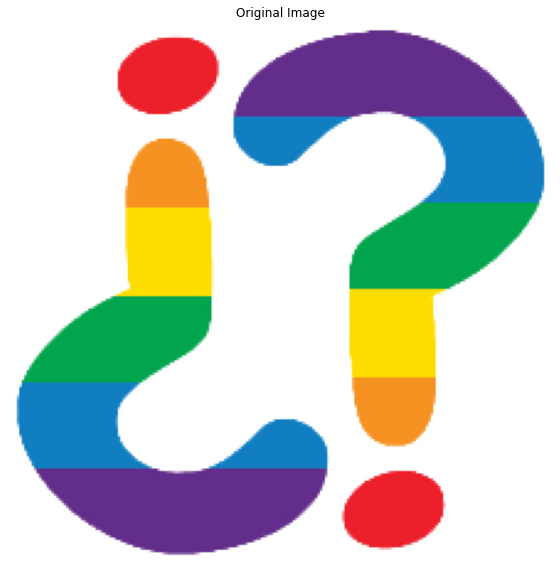

In [97]:
# lets try with an underlying image
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_gradient_magnitude

from wordcloud import WordCloud, ImageColorGenerator

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = os.path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# load text
text = open(path.join(d, '../../data/raw_text.txt')).read()

# load image 
image_wc = np.array(Image.open(os.path.join(d, "../../output/content/wc_img3.jpg")))
# subsample by factor of 3. Very lossy but for a wordcloud we don't really care.
image_color = image_wc[::3, ::3]

# create mask white is "masked out"
image_mask = image_color.copy()
image_mask[image_mask.sum(axis=2) == 0] = 255

# enforce boundaries between colors
edges = np.mean([gaussian_gradient_magnitude(image_color[:, :, i] / 255., 2) for i in range(3)], axis=0)
image_mask[edges > .08] = 255

# create wordcloud
wc = WordCloud(max_words=2000, mask=image_mask, max_font_size=40, random_state=42, 
               relative_scaling=0, scale = 7)

# generate word cloud
wc.generate(text)
#plt.imshow(wc)

# create coloring from image
image_colors = ImageColorGenerator(image_color)
wc.recolor(color_func=image_colors)
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
wc.to_file("../../output/content/image_WC_out.png")

plt.figure(figsize=(10, 10))
plt.title("Original Image")
plt.axis("off")
plt.imshow(image_color)

# plt.figure(figsize=(10, 10))
# plt.title("Edge map")
# plt.imshow(edges)
# plt.show()



### Cleaning
- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming
- Lemetizing (instead of stemming because with the newwer versions it is even better than stemming)